#                                Data Analysis 


# Part 2 : Say Hello to My Little Friends

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

from scipy.interpolate import interp1d
import re

from scipy.optimize import curve_fit

plt.rcParams['text.usetex']=True
plt.style.use('classic')

plt.rcParams['font.size'] = 18

In [2]:
def LoadData():
    d = np.zeros((817,7))
    with open('./Data/PRL2022_SubtractedSpectrumFit_Data.txt', "r") as text_file:
        for j,line in enumerate (text_file):
            a = re.findall(r"[-+]?(?:\d*\.*\d+)", line.split(", ")[0])
            for i in range(len(a)):
                d[j,i] = a[i]

    cond   = [250,510]
    n_th   = [5,6,10]
    d_rbin = [[],[],[],[]]

    for i in range (0,cond[0],n_th[0]):
        d_rbin[0].append(d[i,2])
        d_rbin[1].append(np.sum(d[i:i+n_th[0],3]))
        d_rbin[2].append(np.sum(d[i:i+n_th[0],4]))
        d_rbin[3].append(np.sqrt(np.sum(d[i:i+n_th[0],4])))   

    for i in range (cond[0],cond[1],n_th[1]):
        d_rbin[0].append(d[i,2])
        d_rbin[1].append(np.sum(d[i:i+n_th[1],3]))
        d_rbin[2].append(np.sum(d[i:i+n_th[1],4]))
        d_rbin[3].append(np.sqrt(np.sum(d[i:i+n_th[1],4])))   

    for i in range (cond[1],d.shape[0],n_th[2]):
        d_rbin[0].append(d[i,2])
        d_rbin[1].append(np.sum(d[i:i+n_th[2],3]))
        d_rbin[2].append(np.sum(d[i:i+n_th[2],4]))
        d_rbin[3].append(np.sqrt(np.sum(d[i:i+n_th[2],4])))  

    return np.array(d_rbin)

<ErrorbarContainer object of 3 artists>

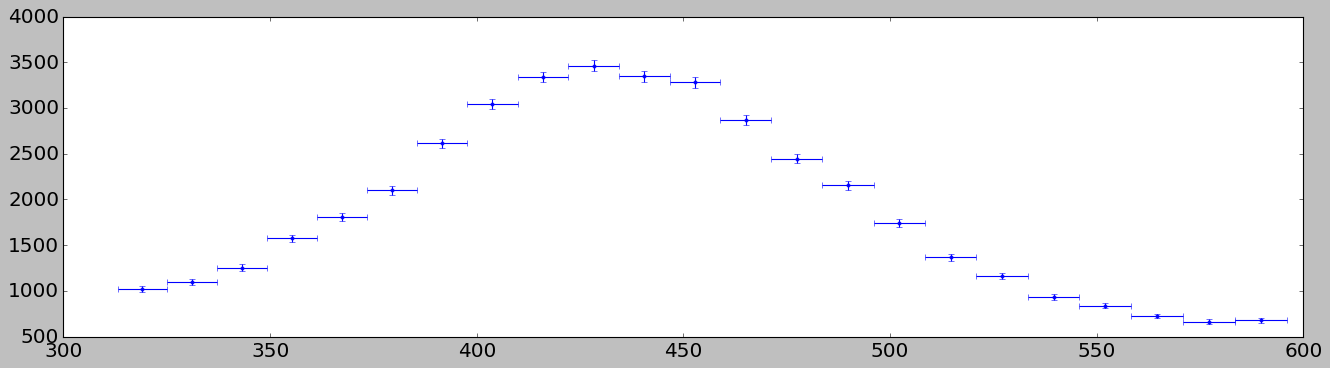

In [3]:
d_rbin = LoadData()

cond = (d_rbin[0]>300)&(d_rbin[0]<600)
expr = d_rbin[:,cond]

plt.figure(figsize=(20,5))
plt.errorbar(expr[0],expr[2],expr[3],expr[1]/2,fmt='.')

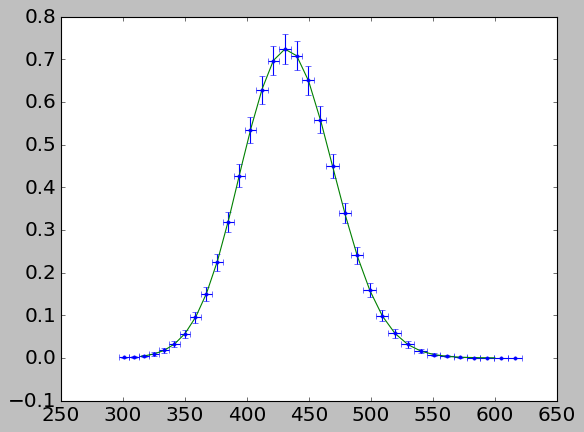

In [13]:
po210 = np.array(pd.read_csv('./Background/Po210_pdfkeV__11.txt',header = None))


cond      = (po210[:,0]>300.)&(po210[:,0]<630.)
po210_cut = po210[cond,:]
po210_cut[:,0] = po210_cut[:,0] - 10
po210_cut[:,1] = po210_cut[:,1] - 10

po210_fit = interp1d((po210_cut[:,0]+po210_cut[:,1])/2,po210_cut[:,2])

plt.errorbar((po210_cut[:,0]+po210_cut[:,1])/2,po210_cut[:,2],po210_cut[:,3],
             (po210_cut[:,1]-po210_cut[:,0])/2,fmt='.')
plt.plot(np.arange(315,600,0.1),po210_fit(np.arange(315,600,0.1)))

[1004.2618537  3671.86726619] [ 56.9851779  162.25564315]


<ErrorbarContainer object of 3 artists>

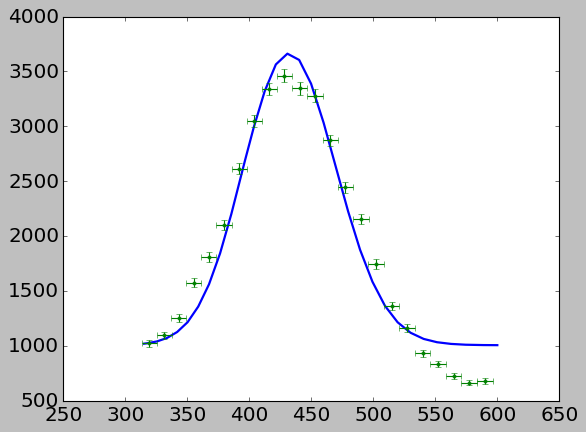

In [14]:
def model(e,be7,norm):
    return be7 + norm*po210_fit(e)


popt, pcov = curve_fit(model, expr[0],expr[2])
perr       = np.sqrt(np.diag(pcov))

print(popt,np.sqrt(np.diag(pcov)))


plt.xlim(250,650)
plt.plot(np.arange(315,600,0.1), model(np.arange(315,600,0.1), *popt), *popt,
         'k--',lw=2,label='fixed')

plt.errorbar(expr[0],expr[2],expr[3],expr[1]/2,fmt='.')

[5640.10765281] [456.94119287]


<ErrorbarContainer object of 3 artists>

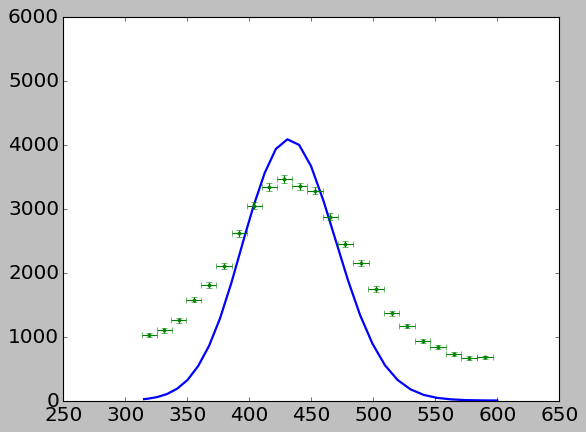

In [15]:
def model2(e,norm):
    return norm*po210_fit(e)


popt2, pcov2 = curve_fit(model2, expr[0],expr[2])
perr2       = np.sqrt(np.diag(pcov))

print(popt2,np.sqrt(np.diag(pcov2)))


plt.xlim(250,650)
plt.plot(np.arange(315,600,0.1), model2(np.arange(315,600,0.1), *popt2), *popt2,
         'k--',lw=2,label='fixed')

plt.errorbar(expr[0],expr[2],expr[3],expr[1]/2,fmt='.')

In [16]:
be7s  = np.arange(300,1300,2)
norms = np.arange(3000,4500,5)

def Chi(be7,norm):
    return np.sum((model(expr[0],be7,norm)-expr[2])**2/expr[3]**2)

chi = [[],[],[]]

for i in range(be7s.shape[0]):
    for j in range(norms.shape[0]):
        chi[0].append(Chi(be7s[i],norms[j]))
        chi[1].append(be7s[i])
        chi[2].append(norms[j])

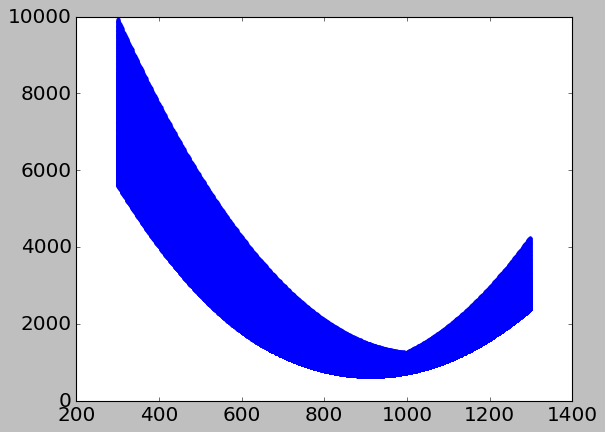

In [17]:
plt.plot(chi[1],chi[0],'.')

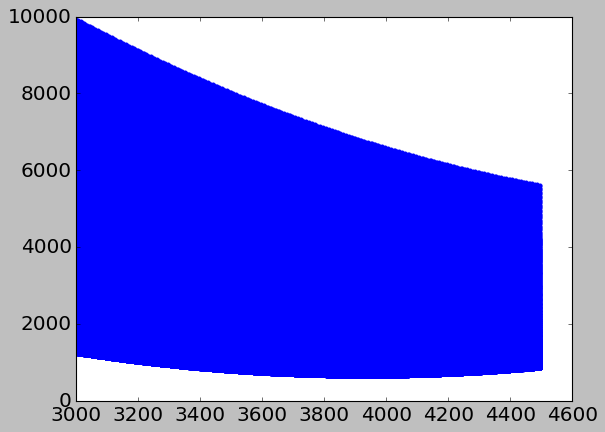

In [18]:
plt.plot(chi[2],chi[0],'.')

In [19]:
chi  = np.array(chi)
cond = chi[0]==np.min(chi[0])
chi_min = chi[0,cond]
print(chi[2,cond],chi[1,cond],chi_min)

[3940.] [912.] [640.50912366]


<ErrorbarContainer object of 3 artists>

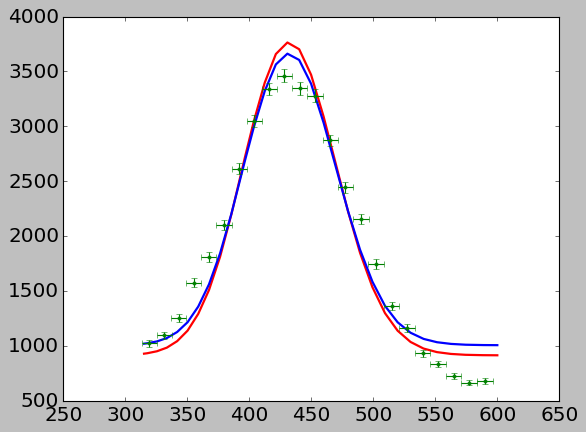

In [20]:
plt.xlim(250,650)

plt.plot(np.arange(315,600,0.1),model(np.arange(315,600,0.1), 912,3940),'r-',lw=2)

plt.plot(np.arange(315,600,0.1), model(np.arange(315,600,0.1), *popt), *popt,
         'k--',lw=2,label='fixed')

plt.errorbar(expr[0],expr[2],expr[3],expr[1]/2,fmt='.')

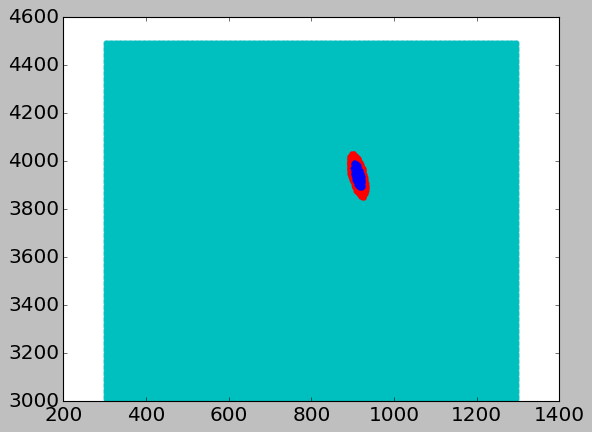

In [21]:
plt.plot(chi[1],chi[2],'c.',alpha=0.5)
plt.plot(chi[1,(chi[0]-chi_min)<5.99],chi[2,(chi[0]-chi_min)<5.99],'r.')
plt.plot(chi[1,(chi[0]-chi_min)<2.28],chi[2,(chi[0]-chi_min)<2.28],'b.')

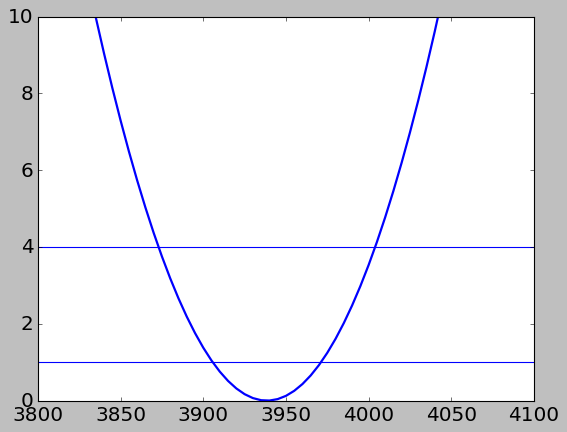

In [26]:
plt.xlim(3800,4100)
plt.ylim(0,10)
plt.plot(chi[2,chi[1]==912.],chi[0,chi[1]==912.]-chi_min,lw=2)
plt.hlines(xmin=3600,xmax=4100,y=1)
plt.hlines(xmin=3600,xmax=4100,y=4)

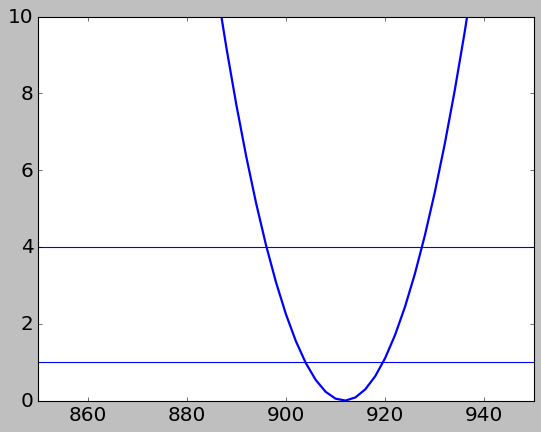

In [28]:
plt.ylim(0,10)
plt.xlim(850,950)
plt.plot(chi[1,chi[2]==3940],chi[0,chi[2]==3940]-chi_min,lw=2)
plt.hlines(xmin=850,xmax=950,y=1)
plt.hlines(xmin=850,xmax=950,y=4)

In [29]:
be7s  = np.arange(300,1300,2)
norms = np.arange(4000,7000,5)

def Chi(norm):
    return np.sum((model2(expr[0],norm)-expr[2])**2/expr[3]**2)

chi2 = [[],[]]

for j in range(norms.shape[0]):
    chi2[0].append(Chi(norms[j]))
    chi2[1].append(norms[j])

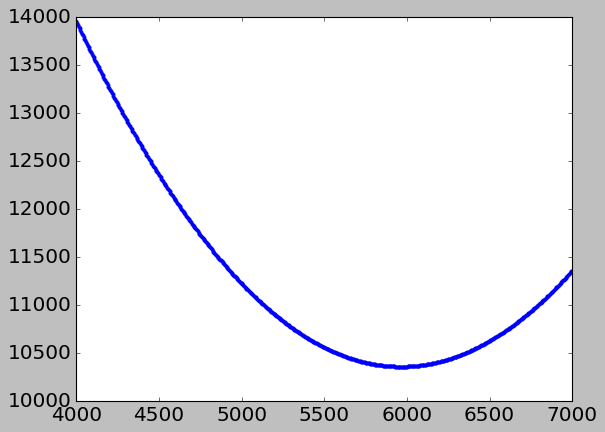

In [30]:
plt.plot(chi2[1],chi2[0],'.')

In [31]:
chi2  = np.array(chi2)
cond2 = chi2[0]==np.min(chi2[0])
chi_min2 = chi2[0,cond2]
print(chi2[1,cond2],chi_min2)

[5965.] [10353.42619411]


<ErrorbarContainer object of 3 artists>

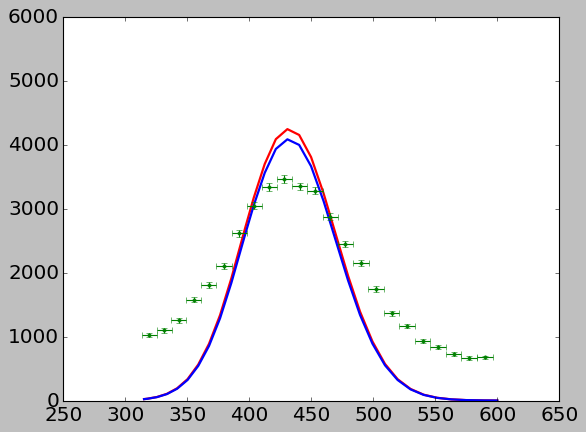

In [32]:
plt.xlim(250,650)

plt.plot(np.arange(315,600,0.1),model2(np.arange(315,600,0.1), 5860),'r-',lw=2)

plt.plot(np.arange(315,600,0.1), model2(np.arange(315,600,0.1), *popt2), *popt2,
         'k--',lw=2,label='fixed')

plt.errorbar(expr[0],expr[2],expr[3],expr[1]/2,fmt='.')

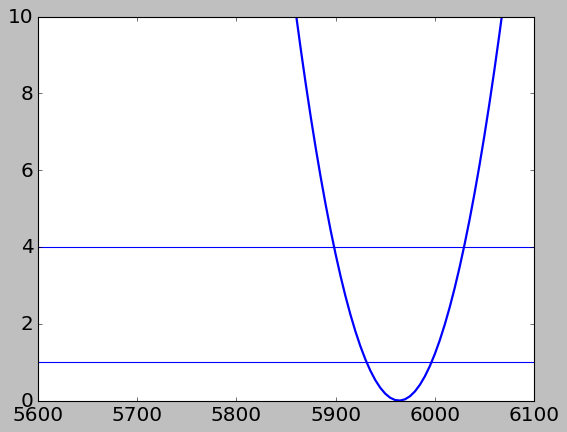

In [34]:
plt.xlim(5600,6100)
plt.ylim(0,10)
plt.plot(chi2[1],chi2[0]-chi_min2,lw=2)
plt.hlines(xmin=5600,xmax=6100,y=1)
plt.hlines(xmin=5600,xmax=6100,y=4)